In [1]:
# import packages
import numpy as np
from datetime import datetime
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import matplotlib
import cartopy.crs as ccrs
import cartopy
from pathlib import Path
import glob
import os
import shutil


In [2]:
from f_catch_characteristics import *

In [3]:
work_dir3=Path("/mnt/u/LSM root zone/global_sr/")
work_dir2=Path("/mnt/u/LSM root zone/for_julia")
work_dir=Path("/mnt/u/LSM root zone/global_sr/data/po_basin/organized_data")

In [4]:
def plot_timeseries(cid):
    qt = pd.read_csv(f'{work_dir}/q_timeseries/{cid}.csv',index_col=0)
    qt.index = pd.to_datetime(qt.index)
   
    plt.figure(figsize=(25,3))
    plt.plot(qt.index,qt.Q)
    plt.ylabel('Q (mm/day)')
    plt.title(f'{cid}, qmean={np.round(qt.Q.mean(),2)}')

In [140]:
no =  pd.read_csv(f'{work_dir}/Italy_network_overview.csv',index_col=0,delimiter=';')
c = no[['lon','lat','area_calc','area_calc_label']]
c = c[c.area_calc_label==0]

t = pd.read_csv(f'{work_dir}/timeseries_ITo.csv',index_col=0)
t.index = pd.to_datetime(t.index)
df = pd.DataFrame(index=c.index,columns=['lat','lon','area_calc','area_calc_label','start_year','end_year','total_years','missing_days','q_mean_raw','q_mean_mmday'])
df[['lat','lon','area_calc','area_calc_label']] = no[['lat','lon','area_calc','area_calc_label']]

for cid in c.index:
    st = t[cid].first_valid_index()
    en = t[cid].last_valid_index()
    ts = t[cid].loc[st:en]
    d = pd.DataFrame(index=ts.index,columns=['q_raw','Q'])
    d['q_raw'] = ts
    d['Q'] = (d['q_raw']/(c.loc[cid]['area_calc']*10e6))*1000*86400 # convert m3/s to mm/day
    d.to_csv(f'{work_dir}/q_timeseries/{cid}.csv')

    syear,eyear,years = ts.index[0].year,ts.index[-1].year,ts.index[-1].year-ts.index[0].year
    missing_days = ts.isna().sum()/len(ts)
    q_mean_m3s = d.q_raw.mean()
    q_mean_mmday = d.Q.mean()
    df.loc[cid,'start_year'] = syear
    df.loc[cid,'end_year'] = eyear
    df.loc[cid,'total_years'] = years
    df.loc[cid,'missing_days'] = missing_days
    df.loc[cid,'q_mean_raw'] = q_mean_m3s
    df.loc[cid,'q_mean_mmday'] = q_mean_mmday
df.to_csv(f'{work_dir}/po_basin_characteristics.csv')

In [141]:
# select catchments based on timseries length and area
df = pd.read_csv(f'{work_dir}/po_basin_characteristics.csv',index_col=0)
# df = df[df.missing_days<0.1]
df = df[df.total_years>10]
df = df[(2010-df.start_year)>10]
df = df[df.area_calc<10000]
df.to_csv(f'{work_dir}/po_basin_characteristics2.csv')

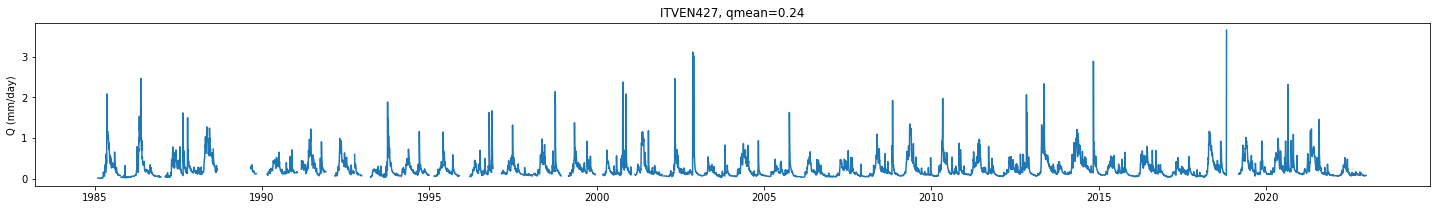

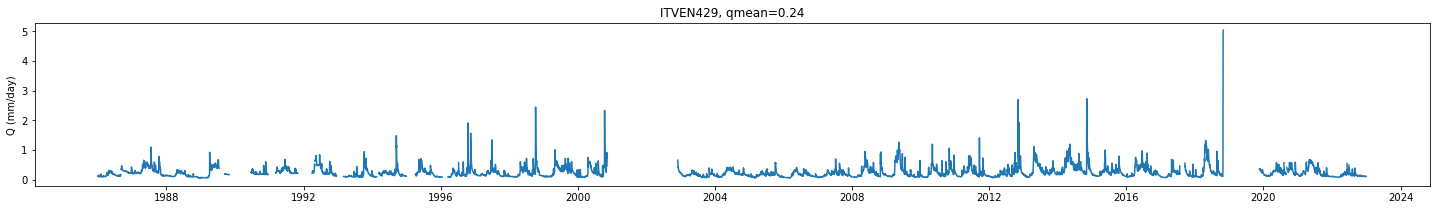

In [144]:
# check individual timesries
cid_list = df.index
for cid in cid_list[0:2]:
    plot_timeseries(cid)

In [145]:
# in excel sheet + looking at timeseries of individual catchments selected useful timeseries for each catchments because there were many gaps in the data
# check y is 'good', check m is 'ok but change in years', check n is 'not good'
dfs = pd.read_csv(f'{work_dir}/it_catchment_selection.csv',index_col=0,delimiter=';')
dfm = dfs[(dfs['check']=='m')]
dfy = dfs[(dfs['check']=='y')]
dfm.loc[:,'start_year'] = dfm.loc[:,'start_year_2']
dfm.loc[:,'end_year'] = dfm.loc[:,'end_year_2']
dfm['start_year'] = dfm['start_year'].astype(int)
dfm['end_year'] = dfm['end_year'].astype(int)
dfs = pd.concat([dfy,dfm])
dfs = dfs.drop(columns=['Unnamed: 11','check','start_year_2','end_year_2'])
dfs.end_year[dfs.end_year>2010] = 2010

/home/fvanoorschot/miniconda3/envs/sr_env/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/tmp/ipykernel_125/955584673.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['start_year'] = dfm['start_year'].astype(int)
/tmp/ipykernel_125/955584673.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [146]:
# for selected catchments make new characteristics dataframe and save selected timeseries in 'q_timeseries_selected'
df = pd.DataFrame(index=dfs.index,columns=['lat','lon','area_calc','area_calc_label','start_year','end_year','total_years','missing_days','q_mean_raw','q_mean_mmday'])
df[['lat','lon','area_calc','area_calc_label']] = no[['lat','lon','area_calc','area_calc_label']]

for cid in dfs.index:
    d = pd.read_csv(f'{work_dir}/q_timeseries/{cid}.csv',index_col=0)
    d.index = pd.to_datetime(d.index)

    syear = dfs.loc[cid,'start_year']
    eyear = dfs.loc[cid,'end_year']
    years = eyear-syear
    d = d.loc[f'{syear}-01-01':f'{eyear}-12-31']
    d.to_csv(f'{work_dir}/q_timeseries_selected/{cid}.csv')
    missing_days = d.isna().sum()/len(d)
    q_mean_m3s = d.q_raw.mean()
    q_mean_mmday = d.Q.mean()
    df.loc[cid,'start_year'] = syear
    df.loc[cid,'end_year'] = eyear
    df.loc[cid,'total_years'] = years
    df.loc[cid,'missing_days'] = missing_days.Q
    df.loc[cid,'q_mean_raw'] = q_mean_m3s
    df.loc[cid,'q_mean_mmday'] = q_mean_mmday
df.to_csv(f'{work_dir}/po_basin_characteristics_final.csv')
np.savetxt(f'{work_dir}/it_selected_catchments.txt',df.index.values.tolist(),fmt='%s')

In [147]:
df

,lat,lon,area_calc,area_calc_label,start_year,end_year,total_years,missing_days,q_mean_raw,q_mean_mmday
new_code,,,,,,,,,,
ITVEN427,46.442646,11.986889,108.963,0,1985,2010,25,0.138901,2.905897,0.230417
ITVEN429,46.559269,12.547678,131.348,0,1986,2010,24,0.178951,3.401035,0.223718
ITVEN433,46.595520,12.108680,81.405,0,1992,2010,18,0.008692,2.186796,0.232098
ITVEN435,46.440019,12.010586,56.668,0,1993,2010,17,0.182027,1.533993,0.233883
ITLOM124,45.789438,9.430142,4556.630,0,1998,2010,12,0.116857,161.278486,0.305806
ITLOM128,45.710215,9.587380,768.053,0,1970,2010,40,0.054709,27.494621,0.309293
ITLOM130,45.592356,10.441073,943.110,0,1970,2010,40,0.131886,30.547361,0.27985
ITLOM132,45.835384,9.232367,52.577,0,1998,2010,12,0.145907,1.654027,0.271807
ITLOM137,45.392637,10.706292,2297.406,0,1971,2010,39,0.117144,23.811923,0.089551


In [160]:
# update total catch id list with correct italian catchments
catch_id_list = np.genfromtxt(f'{work_dir3}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',dtype='str')[:] 
catch_id_list = np.delete(catch_id_list,np.arange(6422,6456,1))
itlist = np.genfromtxt(f'{work_dir}/it_selected_catchments.txt',dtype='str')
l = np.concatenate((catch_id_list,itlist))
np.savetxt(f'{work_dir3}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',l,fmt='%s')

In [39]:
itlist = np.genfromtxt(f'{work_dir}/it_selected_catchments.txt',dtype='str')
for filepath in glob.iglob(f'/mnt/c/Users/fransjevanoors/Documents/shapes/final_shapes/*.shp'):
    f= os.path.split(filepath)[1]
    f2 = f[3:-4]
    if f2 in itlist:
        des = os.path.join(f'/mnt/c/Users/fransjevanoors/Documents/selected_shapes/', f'{f2}.shp')
        shutil.copyfile(filepath,des)
        
for filepath in glob.iglob(f'/mnt/c/Users/fransjevanoors/Documents/shapes/final_shapes/*.dbf'):
    f= os.path.split(filepath)[1]
    f2 = f[3:-4]
    if f2 in itlist:
        des = os.path.join(f'/mnt/c/Users/fransjevanoors/Documents/selected_shapes/', f'{f2}.dbf')
        shutil.copyfile(filepath,des)
        
for filepath in glob.iglob(f'/mnt/c/Users/fransjevanoors/Documents/shapes/final_shapes/*.shx'):
    f= os.path.split(filepath)[1]
    f2 = f[3:-4]
    if f2 in itlist:
        des = os.path.join(f'/mnt/c/Users/fransjevanoors/Documents/selected_shapes/', f'{f2}.shx')
        shutil.copyfile(filepath,des)
        
for filepath in glob.iglob(f'/mnt/c/Users/fransjevanoors/Documents/shapes/final_shapes/*.prj'):
    f= os.path.split(filepath)[1]
    f2 = f[3:-4]
    if f2 in itlist:
        des = os.path.join(f'/mnt/c/Users/fransjevanoors/Documents/selected_shapes/', f'{f2}.prj')
        shutil.copyfile(filepath,des)

In [51]:
c=[]
for catch_id in itlist:
    if(os.path.exists(f'{work_dir3}/output/catchment_characteristics/gswp-p_gleam-ep_gswp-t/landscape/{catch_id}.csv')==True):
        cc = pd.read_csv(f'{work_dir3}/output/catchment_characteristics/gswp-p_gleam-ep_gswp-t/landscape/{catch_id}.csv',index_col=0)
        c.append(cc)

In [53]:
cd = pd.concat(c)
cd.columns

Index(['tc', 'ntc', 'nonveg', 'area', 'el_mean', 'el_min', 'el_max', 'el_std',
       'slp_mean', 'slp_max', 'slp_min', 'slp_std', 'iwu', 'ia', 'kg', 'lat',
       'lon', 'bp', 'dtb', 'pclay', 'psand', 'pcarb', 'bulk', 'stext'],
      dtype='object')

In [ ]:
# import the module
import shutil

# Specify the path of the file you want to copy
file_to_copy = './demo.py'

# Specify the path of the destination directory you want to copy to
destination_directory = './projects'

# Use the shutil.copy() method to copy the file to the destination directory
shutil.copy(file_to_copy, destination_directory)

In [162]:
# define climate and snow variables 
var_cl=['p_mean','ep_mean','q_mean']
var_sn=[]
work_dir3=Path("/mnt/u/LSM root zone/global_sr")
# catchment id list
catch_id_list = np.genfromtxt(f'{work_dir}/it_selected_catchments.txt',dtype='str')[:] 
data_sources = 'gswp-p_gleam-ep_gswp-t'
cc=[]
for catch_id in catch_id_list:
    cc.append(catch_characteristics_climate(var_cl,var_sn, catch_id,work_dir3,data_sources))

In [164]:
cd = pd.concat(cc)
cd

,p_mean,ep_mean,q_mean,start_year,end_year,years
ITVEN427,2.962905,1.513275,0.230371,1985,2010,25
ITVEN429,2.962418,1.649134,0.225199,1986,2010,24
ITVEN433,2.734078,1.633127,0.231255,1992,2010,18
ITVEN435,3.171854,1.532998,0.234327,1993,2010,17
ITLOM124,3.519951,1.434058,0.306391,1998,2010,12
ITLOM128,3.470992,1.761098,0.309014,1981,2010,29
ITLOM130,3.390031,1.589191,0.273647,1981,2010,29
ITLOM132,3.634601,2.005321,0.274046,1998,2010,12
ITLOM137,3.027804,1.588067,0.070795,1981,2010,29
ITPIE168,2.116629,1.87567,0.11203,1995,2006,11


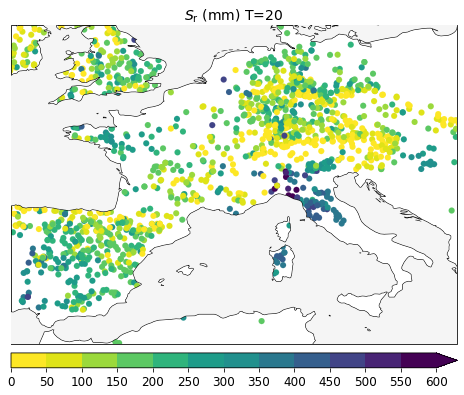

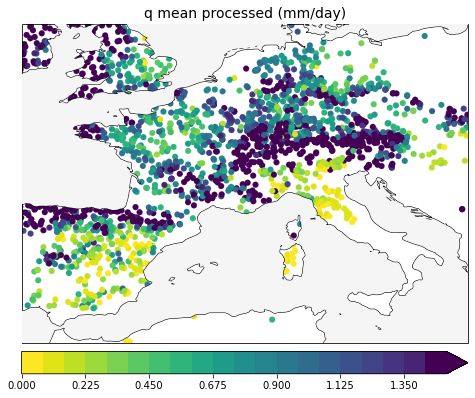

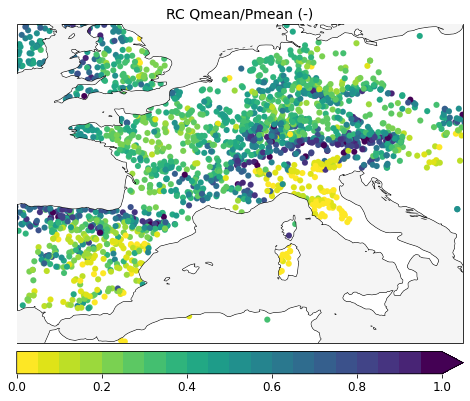

In [276]:
# plot Sr
sr = pd.read_csv(f'{work_dir3}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_gumbelfit_rzyear.csv',index_col=0)
sr = sr.dropna()
coo = pd.read_csv(f'{work_dir2}/master_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
coo['sr_20'] = sr['20.0']

cmap_vd2 = cm.get_cmap('viridis_r', 21)
bounds = np.linspace(0,600,13)
bounds2 = np.linspace(0,600,13)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-8,20)
ax.set_ylim(35,55)
s = ax.scatter(coo.lon,coo.lat,c=coo['sr_20'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
ax.set_title('$S_\mathrm{r}$ (mm) T=20',size=14)
fig.savefig(f'{work_dir2}/sr_fig.jpg', bbox_inches='tight',dpi=300)

# Q mean processed
cmap_vd2 = cm.get_cmap('viridis_r', 21)
bounds = np.linspace(0,1.5,21)
bounds2 = np.linspace(0,1.5,21)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
# ax.set_xlim(-180,180)
# ax.set_ylim(-60,90)
ax.set_xlim(-8,20)
ax.set_ylim(35,55)
s = ax.scatter(coo.lon,coo.lat,c=coo['q_mean'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.02, norm=norm)
ax.set_title('q mean processed (mm/day)',size=14)
fig.savefig(f'{work_dir2}/q_fig.jpg', bbox_inches='tight',dpi=300)

# RC
cmap_vd2 = cm.get_cmap('viridis_r', 21)
bounds = np.linspace(0,1,21)
bounds2 = np.linspace(0,1,6)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-8,20)
ax.set_ylim(35,55)
s = ax.scatter(coo.lon,coo.lat,c=coo.q_mean/coo.p_mean,cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.02, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
ax.set_title('RC Qmean/Pmean (-)',size=14)
fig.savefig(f'{work_dir2}/rc_fig.jpg', bbox_inches='tight',dpi=300)


/home/fvanoorschot/miniconda3/envs/sr_env/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/tmp/ipykernel_123/1395949910.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pp = coo[214:345][coo.q_mean>coo.p_mean]


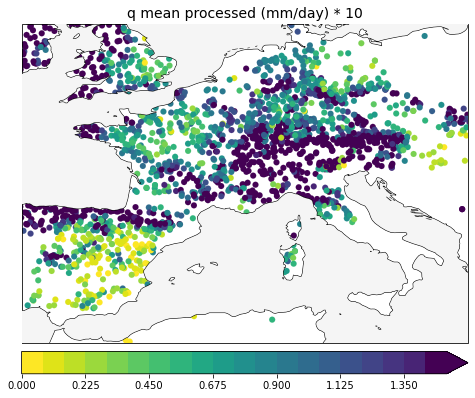

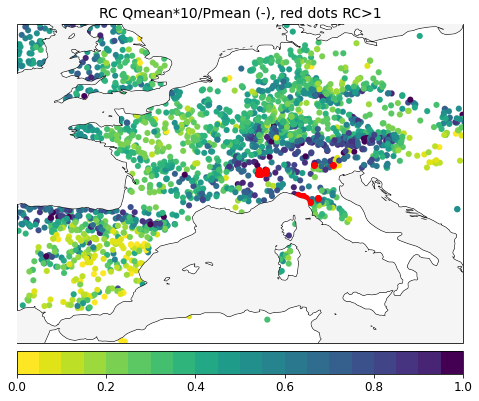

In [274]:
# Q mean processed
sr = pd.read_csv(f'{work_dir3}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_gumbelfit_rzyear.csv',index_col=0)
sr = sr.dropna()
coo = pd.read_csv(f'{work_dir2}/master_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
coo['sr_20'] = sr['20.0']
coo = coo.sort_index()
coo[214:345].q_mean = coo[214:345].q_mean*10
pp = coo[214:345][coo.q_mean>coo.p_mean]
# pp = coo[coo.q_mean>coo.p_mean]

cmap_vd2 = cm.get_cmap('viridis_r', 21)
bounds = np.linspace(0,1.5,21)
bounds2 = np.linspace(0,1.5,21)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
# ax.set_xlim(-180,180)
# ax.set_ylim(-60,90)
ax.set_xlim(-8,20)
ax.set_ylim(35,55)
s = ax.scatter(coo.lon,coo.lat,c=coo['q_mean'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.02, norm=norm)
ax.set_title('q mean processed (mm/day) * 10',size=14)
fig.savefig(f'{work_dir2}/q_fig.jpg', bbox_inches='tight',dpi=300)

# RC
cmap_vd2 = cm.get_cmap('viridis_r', 21)
bounds = np.linspace(0,1,21)
bounds2 = np.linspace(0,1,6)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-8,20)
ax.set_ylim(35,55)
s = ax.scatter(coo.lon,coo.lat,c=coo.q_mean/coo.p_mean,cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
ax.plot(pp.lon,pp.lat,'ro')
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='neither', pad=0.02, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
ax.set_title('RC Qmean*10/Pmean (-), red dots RC>1',size=14)
fig.savefig(f'{work_dir2}/rc_fig.jpg', bbox_inches='tight',dpi=300)


In [269]:
pp = coo[214:345][coo.q_mean>coo.p_mean]

/tmp/ipykernel_123/4273786992.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  coo[214:345][coo.q_mean>coo.p_mean]


,p_mean,ep_mean,q_mean,t_mean,ai,hai,tdiff_max,tdiff_mean,idu_mean,idu_max,...,lat,lon,bp,dtb,pclay,psand,pcarb,bulk,stext,sr_20
ITEMI009,1.905179,2.109574,3.460480,9.448777,0.903111,0.823064,22.700005,19.513334,8.28,36.40,...,44.054038,10.905569,0.000000,11.56,29.438080,33.656929,6.513527,124.682910,SaClLo,248.121123
ITLIG307,3.068138,2.199493,3.120839,10.659697,0.716882,0.565479,21.244584,18.222673,8.02,40.25,...,44.198020,9.950150,0.000000,14.59,31.065536,33.393769,5.166385,129.188504,SiClLo,482.711352
ITLIG319,3.103449,2.205722,3.213678,12.804340,0.710733,0.667339,21.100003,18.063334,8.26,39.30,...,44.278080,9.655950,0.000000,13.06,32.028669,32.504553,4.965776,130.939788,SiClLo,562.414570
ITTOS374,2.499413,2.313577,5.671910,8.912980,1.080324,0.590773,21.900007,18.492858,8.62,39.04,...,44.058293,10.168121,0.000000,9.22,29.876480,34.833098,5.625192,126.545512,SiClLo,337.008964
ITTOS384,2.171379,2.350088,2.976903,10.795964,0.923957,0.811500,22.173727,19.194651,7.56,34.08,...,43.818859,10.414257,0.000000,14.34,30.073690,34.011397,5.781178,127.175359,SiClLo,328.923102
ITTOS389,3.068138,2.199493,3.126388,10.659697,0.716882,0.565479,21.244584,18.222673,8.02,40.25,...,44.201787,9.951040,0.000000,14.59,31.062537,33.392646,5.168411,129.191316,SiClLo,482.538337
ITTRE245,3.048319,1.539999,3.254935,2.568135,0.505196,0.229854,20.600000,18.194118,4.30,21.82,...,46.174083,11.829937,0.000000,11.67,15.311054,48.773659,6.971187,122.442418,SiLo,255.505045
ITTRE270,2.882559,1.220068,5.168230,0.561805,2.362621,0.169850,20.000005,17.076471,4.37,21.00,...,46.166699,10.661162,0.000000,9.01,13.188965,56.884544,6.500417,129.948033,SaLo,168.716969
ITVAL289,2.554198,1.554742,4.272605,4.983375,1.642843,0.376355,20.299999,17.627273,4.39,19.27,...,45.620600,7.608750,0.000000,11.78,16.342154,49.599848,5.651436,130.642027,SiLo,NaN
ITVAL290,3.033394,1.382236,3.312011,3.127277,0.455673,0.247053,19.949999,17.122727,3.66,19.36,...,45.614500,7.340480,0.017544,5.55,15.670950,51.577735,5.260228,137.250996,SaLo,NaN


In [275]:
coo[214:345]

,p_mean,ep_mean,q_mean,t_mean,ai,hai,tdiff_max,tdiff_mean,idu_mean,idu_max,...,lat,lon,bp,dtb,pclay,psand,pcarb,bulk,stext,sr_20
ITEMI002,2.445965,1.806515,0.751046,10.862823,1.353969,0.728356,23.500001,20.553333,7.04,36.37,...,44.507477,11.470171,0.000000,15.51,35.061084,26.697550,3.191641,139.090423,SiClLo,444.651607
ITEMI009,1.905179,2.109574,3.460480,9.448777,0.903111,0.823064,22.700005,19.513334,8.28,36.40,...,44.054038,10.905569,0.000000,11.56,29.438080,33.656929,6.513527,124.682910,SaClLo,248.121123
ITEMI017,1.889195,1.946333,1.346626,10.343549,1.030245,0.901658,23.227747,20.069302,7.97,34.67,...,44.727163,11.045084,0.000000,18.21,32.710756,29.397648,4.274226,137.317902,SiClLo,309.855726
ITEMI039,2.819665,2.093887,2.590182,10.700801,1.346618,0.619720,22.060144,19.074106,8.06,32.64,...,44.755103,9.383694,0.000000,14.11,30.687906,33.460140,5.967706,125.701337,SiClLo,529.014553
ITEMI043,2.122354,1.754393,0.761787,12.421524,0.826626,0.952739,24.596488,21.525771,7.15,34.44,...,44.577447,11.875204,0.000000,22.77,34.146634,24.967835,2.335120,143.365614,SiClLo,382.295691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ITVAL302,2.738207,1.122328,3.768008,5.482861,2.439758,0.374691,20.500139,17.645594,3.62,17.27,...,45.566800,7.208350,0.025000,14.39,15.644763,51.748499,4.624693,135.692926,SaLo,NaN
ITVAL303,2.554198,0.932949,7.380934,4.983375,0.365261,0.376355,20.299999,17.627273,4.39,19.27,...,45.862600,7.611120,0.000000,6.11,16.693395,48.479682,6.435915,133.183824,SiLo,NaN
ITVEN426,2.935404,1.519600,2.546166,2.195907,1.931695,0.225480,21.175016,18.103725,4.03,22.78,...,46.488923,11.848436,0.000000,6.80,19.846321,43.278815,8.420439,121.369109,SiLo,296.813402
ITVEN427,2.962905,1.513275,2.303712,2.307724,0.510740,0.227757,21.241695,18.172313,4.07,23.27,...,46.442646,11.986889,0.000000,9.09,18.307145,44.072128,6.460819,126.402123,SiLo,308.959546


Text(0, 0.5, 'Sr T20 hydro year (mm)')

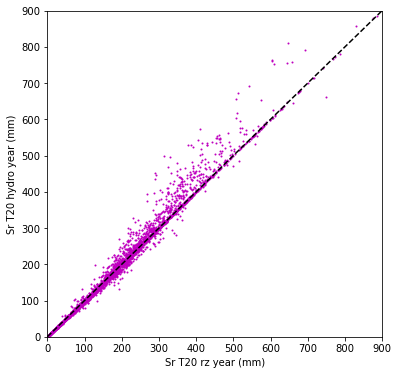

In [8]:
sr1 = pd.read_csv(f'{work_dir3}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_gumbelfit_rzyear.csv',index_col=0)
sr2 = pd.read_csv(f'{work_dir3}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_gumbelfit.csv',index_col=0)
sr1 = sr1.loc[sr2.index]
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(sr1['20.0'],sr2['20.0'],'mo',markersize=1)
ax.plot([0,900],[0,900],'k--')
ax.set_xlim(0,900)
ax.set_ylim(0,900)
ax.set_xlabel('Sr T20 rz year (mm)')
ax.set_ylabel('Sr T20 hydro year (mm)')



Text(0.5, 1.0, '$S_\\mathrm{r}$ reldiff (mm) T=20 ([rz year]-[hydro year])/[hydro year]')

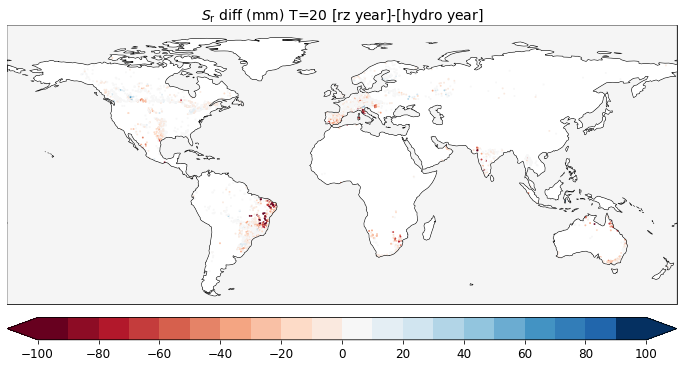

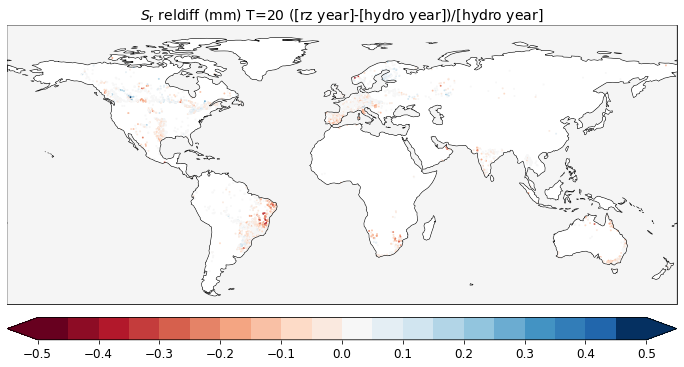

In [21]:
coo = pd.read_csv(f'{work_dir2}/master_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
sr1['lat'] = coo.lat
sr1['lon'] = coo.lon
sr2['lat'] = coo.lat
sr2['lon'] = coo.lon

sr2['dif'] = sr1['20.0'] - sr2['20.0']
sr2['difr'] = ( sr1['20.0'] - sr2['20.0'] ) /sr2['20.0']

cmap_vd2 = cm.get_cmap('RdBu', 21)
bounds = np.linspace(-100,100,21)
bounds2 = np.linspace(-100,100,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr2.lon,sr2.lat,c=sr2['dif'],s=3,cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
ax.set_title('$S_\mathrm{r}$ diff (mm) T=20 [rz year]-[hydro year]',size=14)

cmap_vd2 = cm.get_cmap('RdBu', 21)
bounds = np.linspace(-0.5,0.5,21)
bounds2 = np.linspace(-0.5,0.5,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr2.lon,sr2.lat,c=sr2['difr'],s=3,cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
ax.set_title('$S_\mathrm{r}$ reldiff (mm) T=20 ([rz year]-[hydro year])/[hydro year]',size=14)

Text(0.5, 1.0, '$S_\\mathrm{r}$ diff (mm) T=20 [rz year]-[hydro year]')

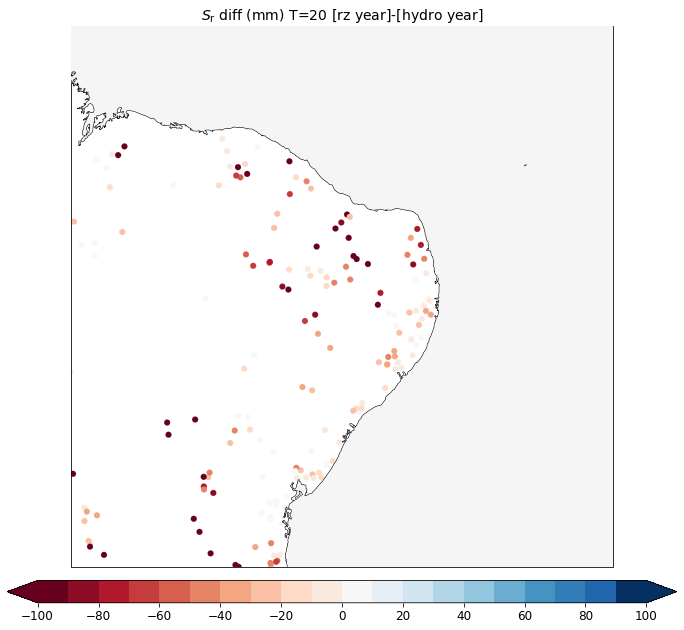

In [26]:
cmap_vd2 = cm.get_cmap('RdBu', 21)
bounds = np.linspace(-100,100,21)
bounds2 = np.linspace(-100,100,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-45,-30)
ax.set_ylim(-15,0)
s = ax.scatter(sr2.lon,sr2.lat,c=sr2['dif'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='both', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
ax.set_title('$S_\mathrm{r}$ diff (mm) T=20 [rz year]-[hydro year]',size=14)

In [27]:
sr2n = sr2[(sr2.lat>-15)& (sr2.lat<0) &(sr2.lon>-45) &(sr2.lon<-30)]
sr2n

,1.5,2.0,3.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,lat,lon,dif,difr
br_0000727,192.949711,215.648017,242.074503,271.507908,308.492017,343.968063,364.376556,378.765175,389.888164,398.957128,406.613739,413.239209,-7.7521,-35.2313,-3.933851,-0.011437
br_0000672,205.222228,253.095335,308.831567,370.909707,448.913072,523.735773,566.779427,597.126533,620.586084,639.713479,655.862075,669.835887,-5.8688,-37.3146,-133.285656,-0.254490
br_0001128,120.807851,139.251848,160.725259,184.642007,214.694241,243.521066,260.104428,271.796210,280.834435,288.203616,294.425160,299.808829,-10.8438,-40.1146,0.000000,0.000000
br_0000649,257.651962,286.615866,320.337071,357.895219,405.088353,450.357140,476.399157,494.759583,508.952942,520.525285,530.295413,538.749766,-6.5563,-39.5104,-63.031399,-0.139959
br_0000557,313.750698,333.657640,356.834284,382.648066,415.083990,446.197308,464.096032,476.715185,486.470306,494.423998,501.139024,506.949716,-3.7063,-44.2896,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
br_0000667,212.100887,247.479879,288.669846,334.546584,392.192318,447.487490,479.297439,501.724436,519.061419,533.196870,545.130940,555.457811,-6.1104,-38.2021,-98.363823,-0.219814
br_0000655,264.061392,304.754780,352.132029,404.900065,471.204957,534.806202,571.394429,597.190259,617.131489,633.390273,647.117000,658.995104,-7.3021,-38.9854,-105.553186,-0.197367
br_0000544,283.838993,303.663143,326.743395,352.449817,384.750841,415.734758,433.559041,446.125711,455.840261,463.760873,470.447971,476.234496,-6.0646,-44.7104,0.000000,0.000000
br_0001153,58.407376,74.778631,93.838854,115.067830,141.742785,167.330042,182.049760,192.427616,200.450122,206.991153,212.513518,217.292169,-12.5229,-38.2938,-1.300443,-0.007772


Text(0.5, 1.0, '$S_\\mathrm{r}$ (mm) T=20')

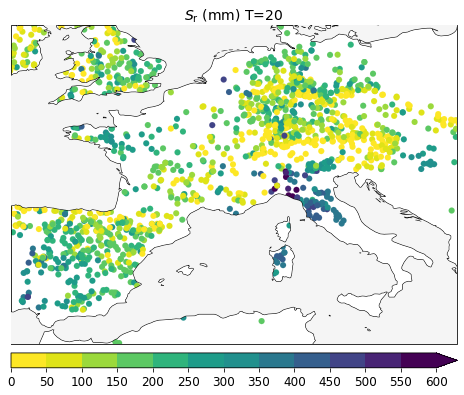

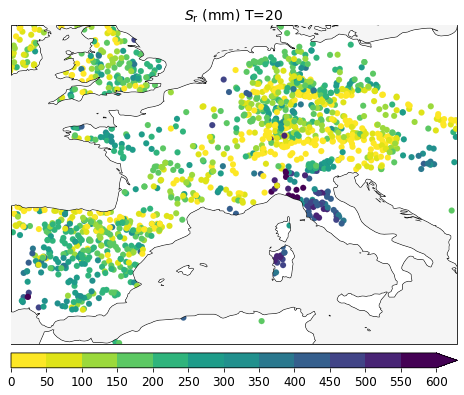

In [209]:
# plot Sr
sr = pd.read_csv(f'{work_dir3}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_gumbelfit_rzyear.csv',index_col=0)
sr = sr.dropna()
sr2 = pd.read_csv(f'{work_dir3}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_gumbelfit.csv',index_col=0)

coo = pd.read_csv(f'{work_dir2}/master_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
coo['sr_20'] = sr['20.0']
coo['sr_20_v2'] = sr2['20']

cmap_vd2 = cm.get_cmap('viridis_r', 21)
bounds = np.linspace(0,600,13)
bounds2 = np.linspace(0,600,13)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-8,20)
ax.set_ylim(35,55)
s = ax.scatter(coo.lon,coo.lat,c=coo['sr_20'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
ax.set_title('$S_\mathrm{r}$ (mm) T=20',size=14)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-8,20)
ax.set_ylim(35,55)
s = ax.scatter(coo.lon,coo.lat,c=coo['sr_20_v2'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='horizontal', label='',spacing='proportional',extend='max', pad=0.02,aspect=30, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
ax.set_title('$S_\mathrm{r}$ (mm) T=20',size=14)

In [166]:
coo = pd.read_csv(f'{work_dir2}/master_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
cd[['lat','lon']] = coo[['lat','lon']]
cd

,p_mean,ep_mean,q_mean,start_year,end_year,years,lat,lon
ITVEN427,2.962905,1.513275,0.230371,1985,2010,25,46.442646,11.986889
ITVEN429,2.962418,1.649134,0.225199,1986,2010,24,46.559269,12.547678
ITVEN433,2.734078,1.633127,0.231255,1992,2010,18,46.595520,12.108680
ITVEN435,3.171854,1.532998,0.234327,1993,2010,17,46.440019,12.010586
ITLOM124,3.519951,1.434058,0.306391,1998,2010,12,45.789438,9.430142
ITLOM128,3.470992,1.761098,0.309014,1981,2010,29,45.710215,9.587380
ITLOM130,3.390031,1.589191,0.273647,1981,2010,29,45.592356,10.441073
ITLOM132,3.634601,2.005321,0.274046,1998,2010,12,45.835384,9.232367
ITLOM137,3.027804,1.588067,0.070795,1981,2010,29,45.392637,10.706292
ITPIE168,2.116629,1.87567,0.11203,1995,2006,11,44.751390,8.542500


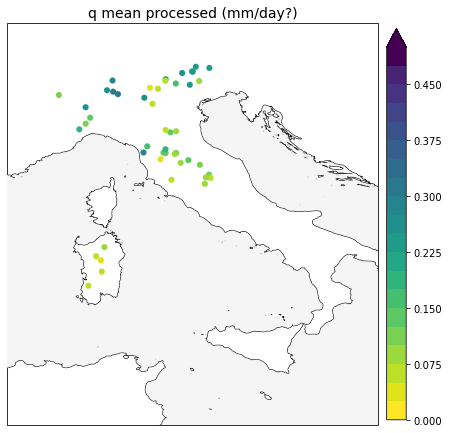

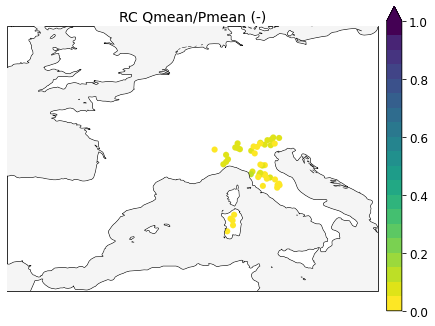

In [171]:
# Q mean processed
cmap_vd2 = cm.get_cmap('viridis_r', 21)
bounds = np.linspace(0,0.5,21)
bounds2 = np.linspace(0,0.5,21)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
# ax.set_xlim(-180,180)
# ax.set_ylim(-60,90)
ax.set_xlim(6,18)
ax.set_ylim(35,48)
s = ax.scatter(cd.lon,cd.lat,c=cd['q_mean'],cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='vertical', label='',spacing='proportional',extend='max', pad=0.02, norm=norm,shrink=0.9)
ax.set_title('q mean processed (mm/day?)',size=14)
fig.savefig(f'{work_dir2}/qprocessed_fig.jpg', bbox_inches='tight',dpi=300)

#RC
rc = cd.q_mean/cd.p_mean
cmap_vd2 = cm.get_cmap('viridis_r', 21)
bounds = np.linspace(0,1,21)
bounds2 = np.linspace(0,1,6)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-8,20)
ax.set_ylim(35,55)
s = ax.scatter(cd.lon,cd.lat,c=rc,cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='vertical', label='',spacing='proportional',extend='max', pad=0.02,shrink=0.7, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
ax.set_title('RC Qmean/Pmean (-)',size=14)
fig.savefig(f'{work_dir2}/rc_fig.jpg', bbox_inches='tight',dpi=300)


In [107]:
co = pd.read_csv(f'{work_dir2}/master_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
df['p_mean'] = co.p_mean
df = df.dropna()

Text(0.5, 1.0, 'RC Qmean/Pmean (-)')

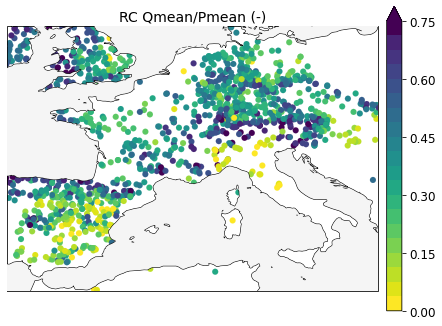

In [181]:
# map runoff coefficient
coo = pd.read_csv(f'{work_dir2}/master_characteristics_gswp-p_gleam-ep_gswp-t.csv',index_col=0)
coo = coo.dropna()
coo = coo.drop(coo.sort_index()[208:321].index)
# co = co.drop(df.index)

rc = coo.q_mean/coo.p_mean
rc2 = co.q_mean/co.p_mean

cmap_vd2 = cm.get_cmap('viridis_r', 21)
bounds = np.linspace(0,0.75,21)
bounds2 = np.linspace(0,0.75,6)
norm = mpl.colors.BoundaryNorm(bounds, cmap_vd2.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN, zorder=100,facecolor='whitesmoke', edgecolor='k',linewidth=0.1)
ax.set_global()
ax.set_xlim(-8,20)
ax.set_ylim(35,55)
s = ax.scatter(coo.lon,coo.lat,c=rc,cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
s = ax.scatter(co.lon,co.lat,c=rc2,cmap=cmap_vd2, norm=norm,edgecolors='face',marker='o',linewidths=0.1)
cbar = plt.colorbar(s, orientation='vertical', label='',spacing='proportional',extend='max', pad=0.02,shrink=0.7, norm=norm,ticks=bounds2)
cbar.ax.tick_params(labelsize=12)
ax.set_title('RC Qmean/Pmean (-)',size=14)